# Trabajo Práctico ACN
## Simulación Molino de Viento

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#### Cargamos los datos del viento

In [23]:
viento = pd.read_excel('WindData.xlsx')
viento

,dia,regional wind,wind gap norte sur
0,1,8.000000,0.000000
1,2,8.346296,0.181523
2,3,10.062316,0.188643
3,4,10.791337,0.071085
4,5,10.754093,0.078442
...,...,...,...
3645,3646,8.642231,-0.869425
3646,3647,6.527408,-1.268447
3647,3648,6.230707,-1.149234
3648,3649,5.550882,-0.420431


#### Visualizamos los datos

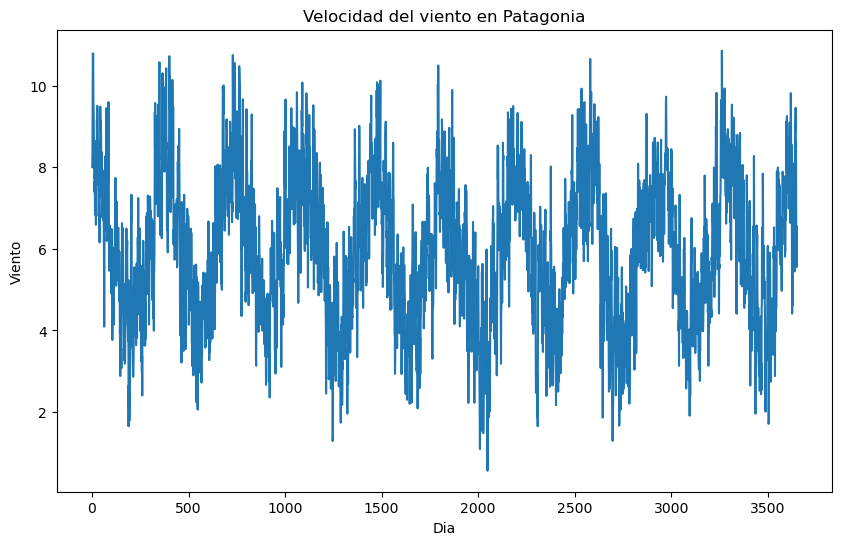

In [24]:
# Graficamos el viento regional de todos los días del dataset
plt.figure(figsize=(10, 6))
plt.plot(viento['dia'], viento['regional wind'])
plt.xlabel('Dia')
plt.ylabel('Viento')
plt.title('Velocidad del viento en Patagonia')
plt.show()

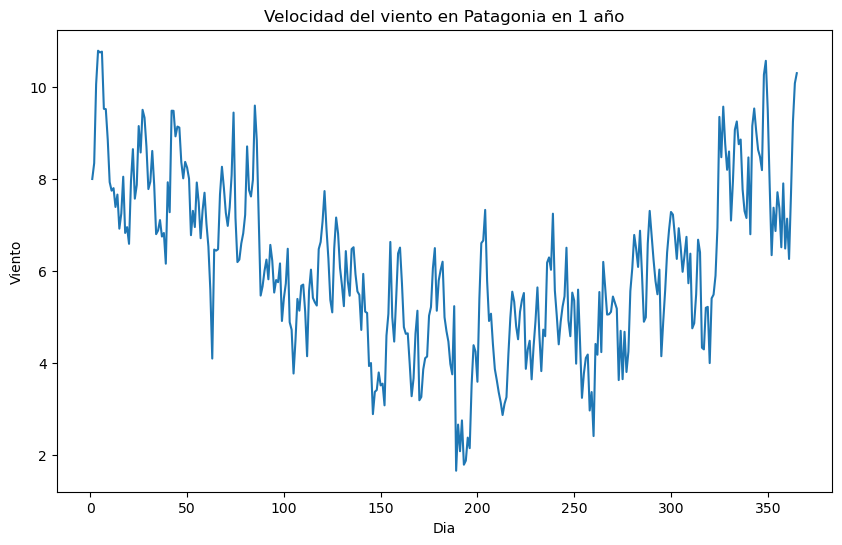

In [25]:
# Graficamos solo un año de los datos históricos
viento_365 = viento[(viento['dia'] >= 1) & (viento['dia'] <= 365)]
plt.figure(figsize=(10, 6))
plt.plot(viento_365['dia'], viento_365['regional wind'])
plt.xlabel('Dia')
plt.ylabel('Viento')
plt.title('Velocidad del viento en Patagonia en 1 año')
plt.show()
    

#### Modelo

La empresa tiene dos molinos de viento en Patagonia, a cierta distancia entre sí. Llamamos a uno molino Norte y al otro molino Sur. Para el viento promedio (espacial) de la región en cada día \(i\) considerará que el siguiente modelo representa bien la realidad:

$$
S_{i+1} = S_i + \kappa (\theta(t_i) - S_i) \Delta + \sigma \sqrt{\Delta} Z_i
$$

con $\Delta = 1/365$ y la media estacional

$$
\theta(t_i) = 6 + 2 \cos\left(\frac{2\pi i}{365}\right)
$$

El reloj \(t_i\) corre en frecuencia diaria y el shock \(Z\) es una variable normal estándar (media = 0, std dev = 1) e independiente entre días consecutivos.

La diferencia de viento entre el molino Norte y el molino Sur es cero el primer día y luego evoluciona como

$$
D_{i+1} = D_i - \beta D_i \Delta + \gamma \sqrt{\Delta} W_i
$$

donde los shocks \(W\) son shocks normalmente distribuidos e independientes de los shocks \(Z\) que impulsan al viento regional.

### Estimamos los valores $ \kappa, \sigma, \beta, \gamma $ usando regresión lineal [1]


Ecuación 1  
 $ S_{i+1} - S_i = \kappa(\theta - S_i)\delta + \sigma\sqrt{\delta}Z $  
 $ S_{i+1} - S_i = Y_i $  
 $ (\theta - S_i)\delta = X_i $  
 $ \sigma\sqrt{\delta} = c $

 Regresión lineal  
 $ Y_i = \kappa X_i + cZ_i $ ----> $ Z_i ~ N(0, c^2) $ 
 

In [26]:
delta = 1/365
theta = 6 + 2 * np.cos(2 * np.pi * np.array(range(3649)) / 365)

Y = (viento["regional wind"][1:]-viento["regional wind"].shift(1)[1:]).values
X = ((theta - viento["regional wind"][:-1])*delta).values

regresion = LinearRegression().fit(X.reshape(-1,1), Y)
Y_pred = regresion.predict(X.reshape(-1,1))
error = Y-Y_pred
c = error.var()
S_0 = viento["regional wind"].iloc[0]
kappa = regresion.coef_[0]
sigma = np.sqrt(c/delta)

# Resultados
print("Estimación de kappa:", kappa)
print("Estimación de sigma:", sigma)

Estimación de kappa: 109.25679788838744
Estimación de sigma: 16.043719733423078


Ecuación 2  
 $ D_{i+1} - D_i = \beta D_i \delta + \gamma\sqrt{\delta}W_i $  
 $ D_{i+1} - D_i = Y_i $  
 $ -D_i\delta = X_i $  
 $ \gamma\sqrt{\delta} = c $

 Regresión lineal  
 $ Y_i = \beta X_i + cZ_i $ ----> $ Z_i ~ N(0, c^2) $ 

In [27]:
Y = (viento["wind gap norte sur"][1:] - viento["wind gap norte sur"].shift(1)[1:]).values
X = (-viento["wind gap norte sur"][:-1] * delta).values

regresion = LinearRegression().fit(X.reshape(-1, 1), Y)
Y_pred = regresion.predict(X.reshape(-1, 1))
error = Y - Y_pred
c = error.var()
beta = regresion.coef_[0] 
gamma = np.sqrt(c / delta)

# Resultados
print("Estimación de beta:", beta)
print("Estimación de gamma:", gamma)


Estimación de beta: 48.377333231943766
Estimación de gamma: 10.09071995713833


In [28]:
# Gráfico de residuos
# plt.figure(figsize=(10, 5))
# plt.plot(error, label='Residuos')
# plt.axhline(error.mean(), color='red', linestyle='--', label='Media')
# plt.xlabel('Días')
# plt.ylabel('Error')
# plt.title('Residuos de la regresión para estimar beta y gamma')
# plt.legend()
# plt.show()


### Simulamos el viento durante un año 

Primero definimos las funciones para simular el viento regional y los gaps entre el viento en el molino norte y sur. <br>
Simulamos y visualizamos los caminos.

In [29]:
def regional_wind_paths(S_0, k, theta, sigma, delta, T, m):   
    #Si+1 - Si = k(theta - si)delta + sigma*raiz(delta)*shock
    S = np.zeros((m,T+1))
    S[:,0] = S_0
    for i in range(m):
        for t in range(1,T+1):
            S[i,t] = S[i, t-1]+k*(theta[t-1]-S[i,t-1])*delta + sigma*np.sqrt(delta)*np.random.normal(0,1)
    return S

def gap_wind_paths(D_0, beta, gamma, delta, T, m):
    D = np.zeros((m, T+1))
    D[:,0] = D_0
    for i in range(m):
        for t in range(1, T+1):
            D[i, t] = D[i, t-1] - beta*D[i, t-1]*delta + gamma*np.sqrt(delta)*np.random.normal(0, 1)
    return D

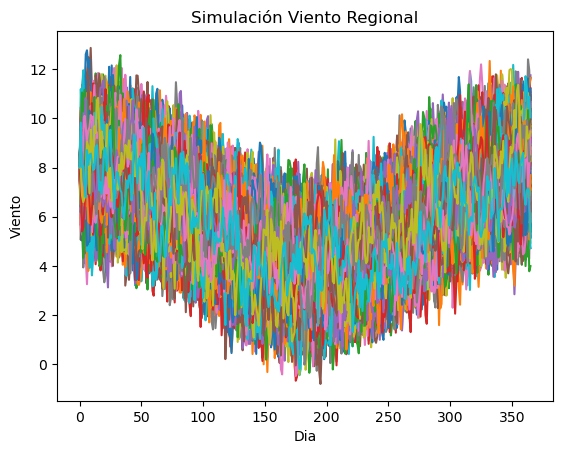

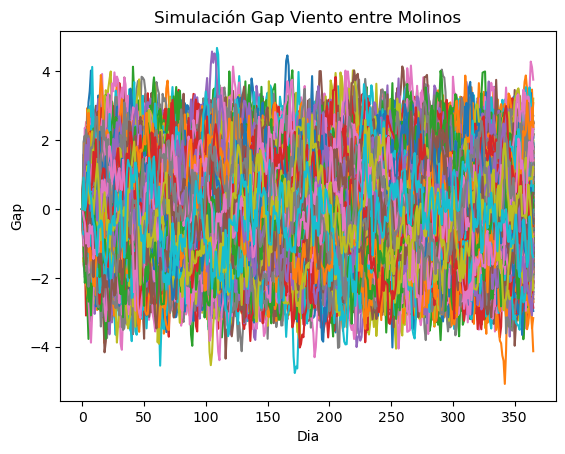

In [30]:
# Simulacion 1 año viento regional y gap entre molinos
S_0 = viento["regional wind"].iloc[0]
D_0 = viento["wind gap norte sur"].iloc[0]
num_sim = 1000
T = 365  # Simulamos 1 año
S = regional_wind_paths(S_0, kappa, theta, sigma,delta, T, num_sim)
D = gap_wind_paths(D_0, beta, gamma, delta, T, num_sim)

# Graficamos los caminos simulados
for s_i in S:
    plt.plot(s_i)
plt.xlabel('Dia')
plt.ylabel('Viento')
plt.title('Simulación Viento Regional')
plt.show()

for d_i in D:
    plt.plot(d_i)
plt.xlabel('Dia')
plt.ylabel('Gap')
plt.title('Simulación Gap Viento entre Molinos')
plt.show()



### Simulamos el viento durante un año en cada molino [2]

A partir de nuestras simulaciones del viento regional y el gap entre molinos generamos el viento en cada molino.  
El viento en el molino norte los definimos como el viento regional más $ 1/2 $ de la diferencia entre molinos. Y así mismo el viento en el molino sur es el viento regional menos $1/2$ de la diferencia entre molinos.

In [31]:
viento_molino_norte = S + 0.5*D
viento_molino_norte= np.maximum(viento_molino_norte, 0) # No tiene sentido que el viento sea negativo

    
viento_molino_sur = S - 0.5*D
viento_molino_sur = np.maximum(viento_molino_sur, 0) # No tiene sentido que el viento sea negativo


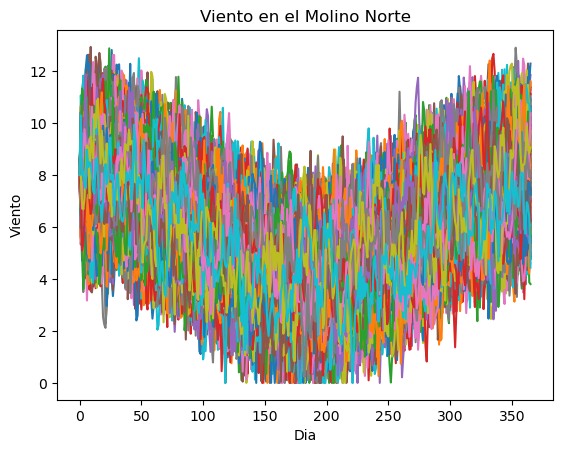

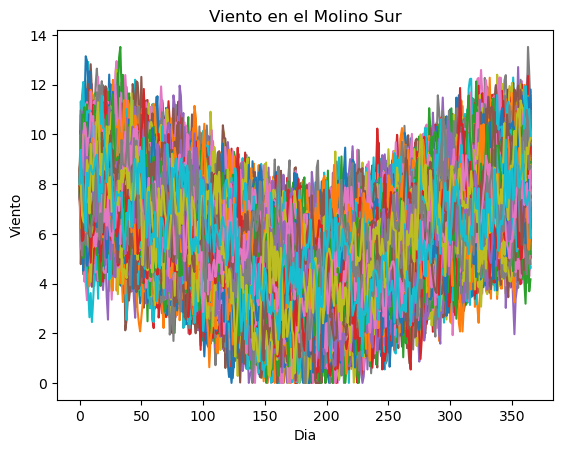

In [32]:
# Graficamos los caminos simulados para el viento en cada uno de los molinos
for vn_i in viento_molino_norte:
    plt.plot(vn_i)
plt.xlabel('Dia')
plt.ylabel('Viento')
plt.title('Viento en el Molino Norte')
plt.show()

for vs_i in viento_molino_sur:
    plt.plot(vs_i)
plt.xlabel('Dia')
plt.ylabel('Viento')
plt.title('Viento en el Molino Sur')
plt.show()

#### Comparación

Vamos a comparar nuestra simulación del viento regional con los datos, para confirmar que nuetros camidos del viento se parecen efectivamente a los datos históricos. <br>

Como tenemos datos de 3650 días = 10 años, graficamos los datos de cada año en un mismo gráfico. Y lo comparamos con 10 simulaciones de un año de viento regional. 

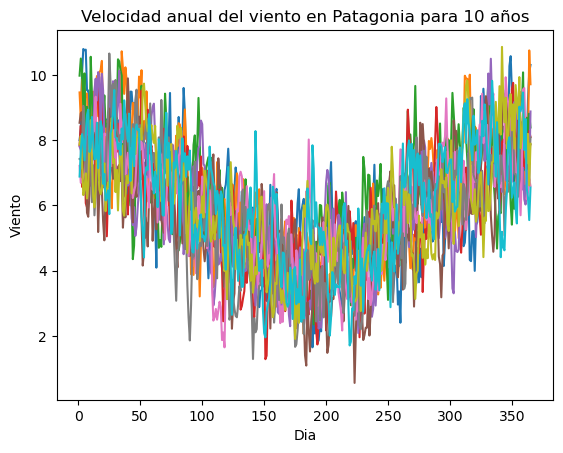

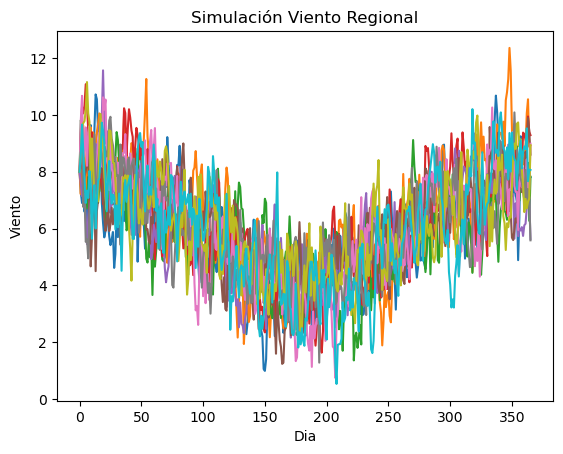

In [33]:
# Gráfico 10 años de datos sobre viento regional
d = 1
for i in range(0,10):
    viento_365 = viento[(viento['dia'] >= d+365*i) & (viento['dia'] <= 365+365*i)]
    plt.plot(viento_365['dia']-365*i, viento_365['regional wind'])
plt.xlabel('Dia')
plt.ylabel('Viento')
plt.title('Velocidad anual del viento en Patagonia para 10 años')
plt.show()


# Simulación 10 años de viento regional
num_sim = 10
S_comp = regional_wind_paths(S_0, kappa, theta, sigma,delta, T, num_sim)

for s_i in S_comp:
    plt.plot(s_i)
plt.xlabel('Dia')
plt.ylabel('Viento')
plt.title('Simulación Viento Regional')
plt.show()

Vemos que los gráficos son parecidos, tienen la misma forma. Nuestra simulación se parece a los datos reales.

Podemos hacer lo mismo con los gaps

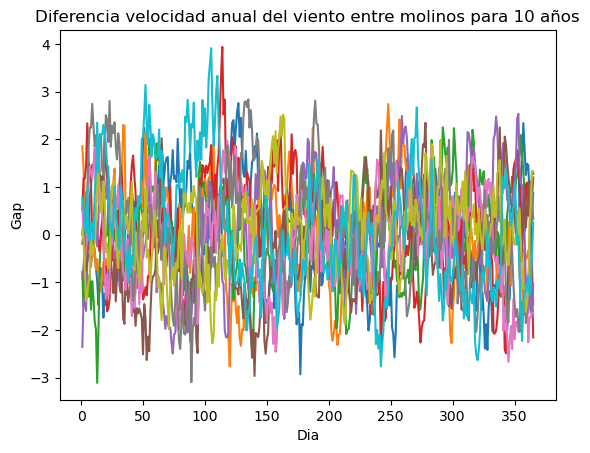

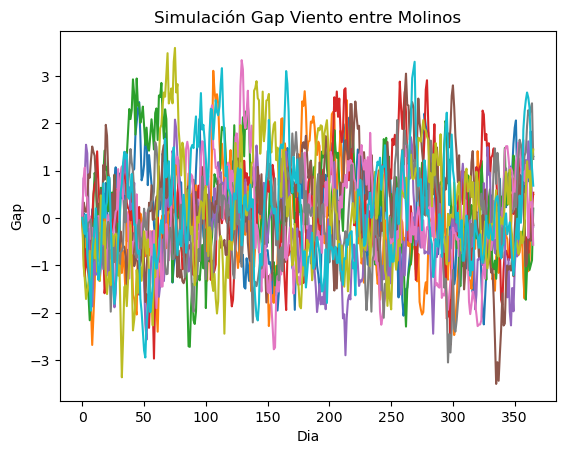

In [34]:
# Gráfico 10 años de datos sobre gap entre viento en molino norte y molino sur
d = 1
for i in range(0,10):
    viento_365 = viento[(viento['dia'] >= d+365*i) & (viento['dia'] <= 365+365*i)]
    plt.plot(viento_365['dia']-365*i, viento_365['wind gap norte sur'])
plt.xlabel('Dia')
plt.ylabel('Gap')
plt.title('Diferencia velocidad anual del viento entre molinos para 10 años')
plt.show()


# Simulación 10 años de gap entre viento en molino norte y molino sur
num_sim = 10
D_comp = gap_wind_paths(D_0, beta, gamma, delta, T, num_sim)

for d_i in D_comp:
    plt.plot(d_i)
plt.xlabel('Dia')
plt.ylabel('Gap')
plt.title('Simulación Gap Viento entre Molinos')
plt.show()

Gráficamos el viento en cada molino usando los datos. Al igual que antes gráficamos 10 años del viento.

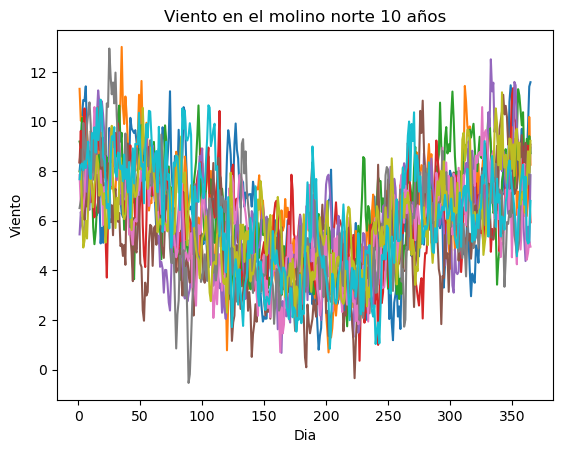

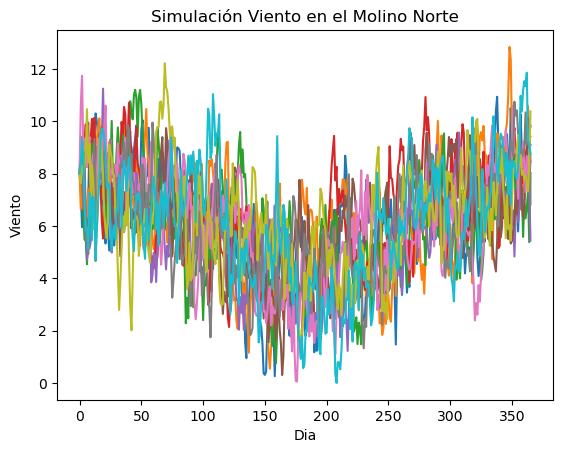

In [35]:
# Gráfico 10 años de datos sobre el viento en el molino norte
d = 1
for i in range(0,10):
    viento_365 = viento[(viento['dia'] >= d+365*i) & (viento['dia'] <= 365+365*i)]
    plt.plot(viento_365['dia']-365*i, viento_365['regional wind'] + viento_365['wind gap norte sur'])
plt.xlabel('Dia')
plt.ylabel('Viento')
plt.title('Viento en el molino norte 10 años')
plt.show()


# Simulación viento en el molino norte
viento_molino_norte_comp = S_comp + D_comp
viento_molino_norte_comp = np.maximum(viento_molino_norte_comp, 0) # No tiene sentido que el viento sea negativo


for vn_i in viento_molino_norte_comp:
    plt.plot(vn_i)
plt.xlabel('Dia')
plt.ylabel('Viento')
plt.title('Simulación Viento en el Molino Norte')
plt.show()


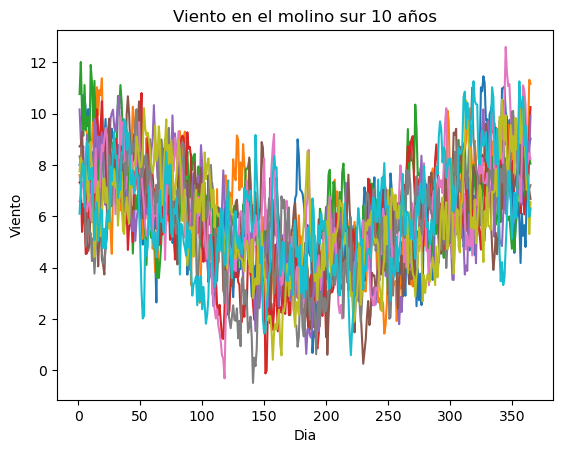

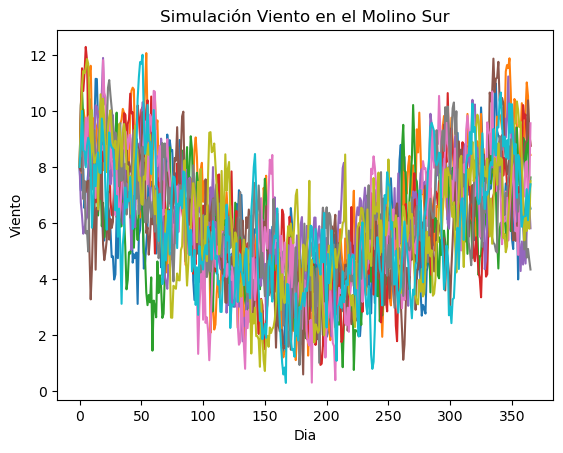

In [36]:
# Gráfico 10 años de datos sobre el viento en el molino sur
d = 1
for i in range(0,10):
    viento_365 = viento[(viento['dia'] >= d+365*i) & (viento['dia'] <= 365+365*i)]
    plt.plot(viento_365['dia']-365*i, viento_365['regional wind'] - viento_365['wind gap norte sur'])
plt.xlabel('Dia')
plt.ylabel('Viento')
plt.title('Viento en el molino sur 10 años')
plt.show()


# Simulación viento en el molino sur
viento_molino_sur_comp = S_comp - D_comp
viento_molino_sur_comp = np.maximum(viento_molino_sur_comp, 0) # No tiene sentido que el viento sea negativo


for vn_i in viento_molino_sur_comp:
    plt.plot(vn_i)
plt.xlabel('Dia')
plt.ylabel('Viento')
plt.title('Simulación Viento en el Molino Sur')
plt.show()

### Simulación Completa [3]

Agregamos la evolución simultánea del tiempo en cada molino, las roturas, las decisiones de apagado y encendido, y la acumulación de cashflows en el tiempo.

In [37]:
def simulate_molino(S, K, delta, repair_cost=200000, shut_cost=1000, income_rate=1000, interest_rate=0.05):
    T = S.shape[1] - 1  
    N = S.shape[0]  
    
    cashflows_sin_descontar = np.zeros((N, T))
    cashflows_descontados = np.zeros((N, T))
    molino_activo = np.ones((N, T), dtype=bool)  # Molino comienza activo
    molino_apagado = np.zeros((N, T), dtype=bool)
    molino_roto = np.zeros((N,T), dtype=bool)
    
    for i in range(N):
        for t in range(T):
            if t==0: # Molino arranca activo
                cashflows_sin_descontar[i, t] += income_rate * S[i, t] #Ingreso en el dia i
            
            # Si el molino estuvo activo el día anterior
            elif molino_activo[i, t-1]:
                prob_rotura = 0.25 * (S[i, t] ** 2) * delta  
                if np.random.rand() < prob_rotura: # Si se rompe el molino   
                    cashflows_sin_descontar[i, t] -= repair_cost # Costo de rotura
                    molino_activo[i, t] = False
                    molino_roto[i, t] = True  
                else: #Si el molino no se rompe
                    # Si se pasa el umbral K, se apaga el molino
                    if S[i, t] > K:
                        cashflows_sin_descontar[i, t] -= shut_cost  #costo de apagado
                        molino_activo[i, t] = False
                        molino_apagado[i, t] = True
                    else: # Si el viento esta debajo del umbral K
                        molino_activo[i, t] = True
                        cashflows_sin_descontar[i, t] += income_rate * S[i, t] #Ingreso en el dia i

            #Si el molino estuvo apagado el día anterior
            else: 
                if S[i, t] < K: # se vuelve a prender si S[i, t] < K
                    molino_activo[i, t] = True  
                    cashflows_sin_descontar[i, t] += income_rate * S[i, t] #Ingreso en el dia i
                else: # Permanece apagado si S[i, t] > K
                    molino_activo[i, t] = False
                    molino_apagado[i, t] = True  
                    # Como ya estaba apagado no volvemos a cobrar el costo de apagado
            
            #Descuento de cashflows por tasas de interes
            cashflows_descontados[i, t] = cashflows_sin_descontar[i, t].copy()
            cashflows_descontados[i, t] *= np.exp(-interest_rate * t / 365)
    
    #Valor Actual Neto esperado
    van_simulaciones = np.sum(cashflows_descontados, axis=1)
    van = np.mean(van_simulaciones)
    error_van = np.std(van_simulaciones)/np.sqrt(N)

    return van, cashflows_descontados, molino_activo, molino_apagado, molino_roto, error_van, cashflows_sin_descontar


In [38]:
K = 7  # Umbral de apagado arbitrario

#Simulacion molino norte
van_norte, cashflows_norte, activo_norte, apagado_norte, roto_norte, se_norte, csdn= simulate_molino(viento_molino_norte, K, delta)

#Simulacion molino sur
van_sur, cashflows_sur, activo_sur, apagado_sur, roto_sur, se_sur, csds= simulate_molino(viento_molino_sur, K, delta)


In [39]:
print(f"VAN esperado molino Norte: ${van_norte:.2f}")
print(f"VAN esperado molino Sur: ${van_sur:.2f}")
print(f"Error estandar van norte: {se_norte:.2f}")
print(f"Error estandar van sur: {se_sur:.2f}")

VAN esperado molino Norte: $250162.63
VAN esperado molino Sur: $263189.15
Error estandar van norte: 13380.80
Error estandar van sur: 13509.45


### Evolución contemporánea del estado de cada molino [4]

Agarramos un camino arbitrario de nuestra simulación y lo graficamos junto con los cambios de estado (activo, apagado o roto) de cada molino

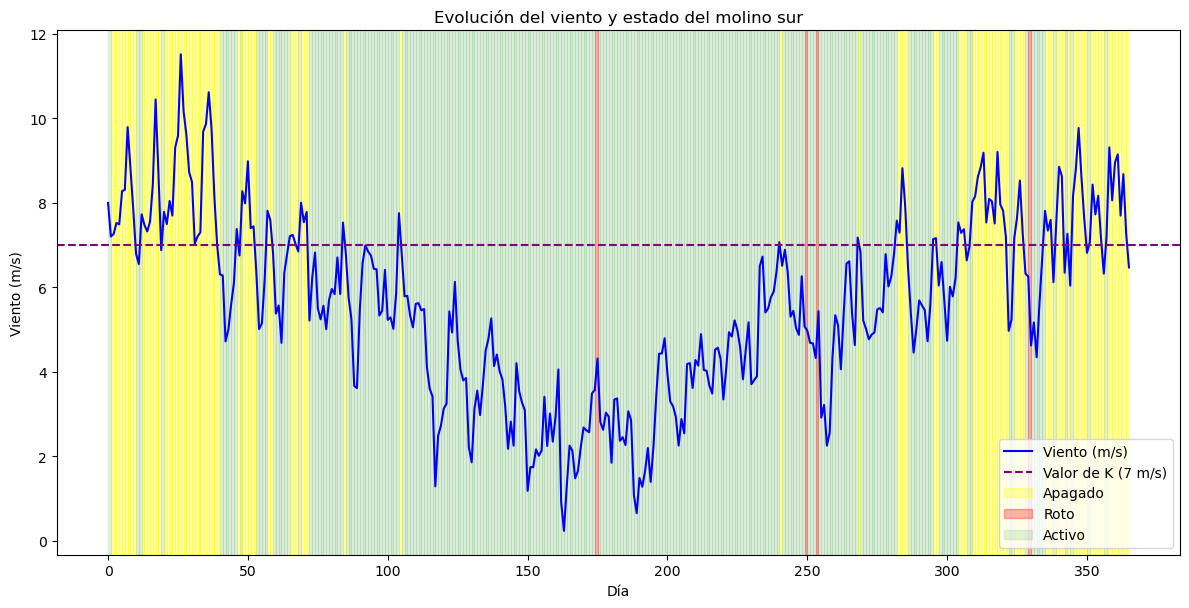

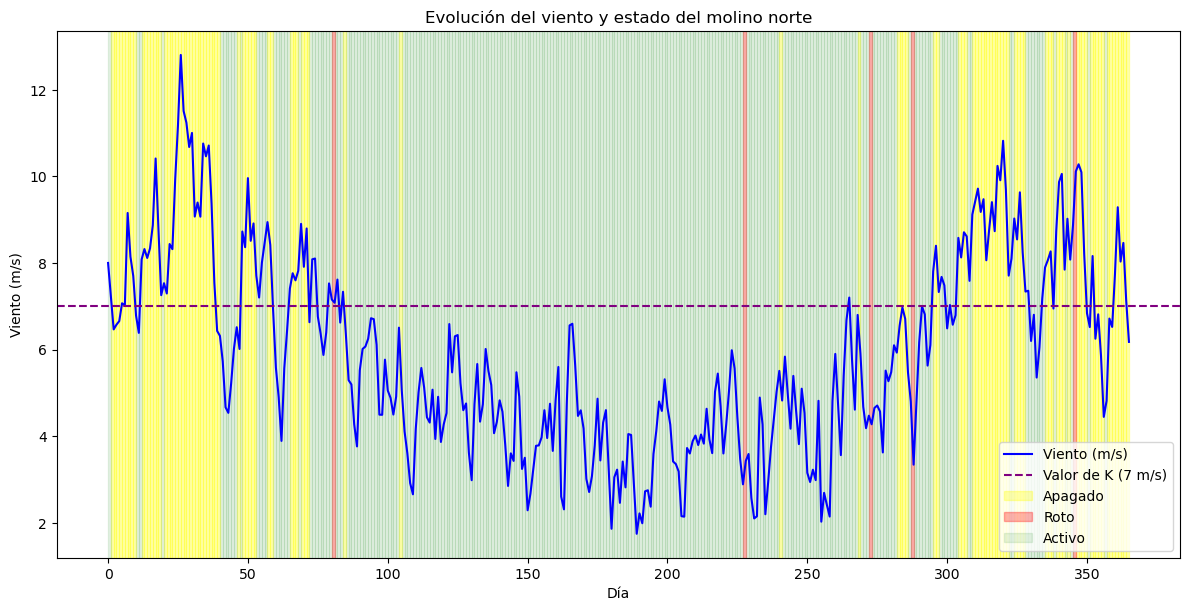

In [40]:
camino_viento_S = viento_molino_sur[0]

_, cashflows, active, shut_downs, breakdowns,_,_ = simulate_molino(
    S=camino_viento_S.reshape(1, -1),
    K=7,
    delta=delta
)

estado_molino = np.ones_like(active[0], dtype=int)
estado_molino[shut_downs[0]] = 0
estado_molino[breakdowns[0]] = -1

fig, ax1 = plt.subplots(figsize=(12, 6))


# Grafico evolución de estado molino Sur
ax1.plot(camino_viento_S, label="Viento (m/s)", color="blue")
ax1.set_xlabel("Día")
ax1.set_ylabel("Viento (m/s)", color="black")
ax1.tick_params(axis='y', labelcolor="black")
ax1.axhline(y=7, color="purple", linestyle="--", label=f"Valor de K ({K} m/s)")

legend_elements = {
    'Apagado': {'color': 'yellow', 'alpha': 0.3},
    'Roto': {'color': 'red', 'alpha': 0.3},
    'Activo': {'color': 'green', 'alpha': 0.1}
}

for state, properties in legend_elements.items():
    indices = np.where(estado_molino == {'Apagado': 0, 'Roto': -1, 'Activo': 1}[state])[0]
    for i in indices:
        ax1.axvspan(i, i+1, color=properties['color'], alpha=properties['alpha'], label=state if i == indices[0] else "")

ax1.legend(loc="lower right")

fig.tight_layout()
plt.title("Evolución del viento y estado del molino sur")
plt.show()



camino_viento_N = viento_molino_norte[0]

_, cashflows, active, shut_downs, breakdowns,_,_ = simulate_molino(
    S=camino_viento_S.reshape(1, -1),
    K=7,
    delta=delta
)

estado_molino = np.ones_like(active[0], dtype=int)
estado_molino[shut_downs[0]] = 0
estado_molino[breakdowns[0]] = -1

fig, ax1 = plt.subplots(figsize=(12, 6))

# Grafico evolución de estado molino Norte
ax1.plot(camino_viento_N, label="Viento (m/s)", color="blue")
ax1.set_xlabel("Día")
ax1.set_ylabel("Viento (m/s)", color="black")
ax1.tick_params(axis='y', labelcolor="black")
ax1.axhline(y=7, color="purple", linestyle="--", label=f"Valor de K ({K} m/s)")

legend_elements = {
    'Apagado': {'color': 'yellow', 'alpha': 0.3},
    'Roto': {'color': 'red', 'alpha': 0.3},
    'Activo': {'color': 'green', 'alpha': 0.1}
}

for state, properties in legend_elements.items():
    indices = np.where(estado_molino == {'Apagado': 0, 'Roto': -1, 'Activo': 1}[state])[0]
    for i in indices:
        ax1.axvspan(i, i+1, color=properties['color'], alpha=properties['alpha'], label=state if i == indices[0] else "")

ax1.legend(loc="lower right")

fig.tight_layout()
plt.title("Evolución del viento y estado del molino norte")
plt.show()

Tienen sentido los gráficos, ya que al principio y al final del año el viento suele ser más fuerte, por lo que se apaga seguido los molinos, durante ese tiempo no se rompe el molino, ya que solo se puede romper si estuvo activo el día anterior. Los molinos estan más días activos en los días entre el principio y final del año, ya que los vientos son más suaves. Y como durante esa parte del año estan más días seguidos activos, se rompen más. También coincide que varias de las roturas son días que hubo más viento que los días anteriores.

### VAN Esperado vs Umbral [5]

In [41]:
umbrales = [0,1,2,3,4,5,6,7,8,9,10,11,12,1000]
vanes_norte = []
errores_norte = []

for u in umbrales:
    vn_u, _,_,_,_, std_error_norte_u,_= simulate_molino(viento_molino_norte, u, delta)
    vanes_norte.append(vn_u)
    errores_norte.append(std_error_norte_u)

mejor_umbral_norte = umbrales[vanes_norte.index(max(vanes_norte))]
mejor_van_norte = vanes_norte[vanes_norte.index(max(vanes_norte))]
se_mejor_umbral_norte = errores_norte[vanes_norte.index(max(vanes_norte))]

se_umbral_sin_apagar_norte = errores_norte[-1]

In [42]:
umbrales = [0,1,2,3,4,5,6,7,8,9,10,11,12,1000]
vanes_sur = []
errores_sur = []

for u in umbrales:
    vs_u, _,_,_,_, std_error_sur_u,_ = simulate_molino(viento_molino_sur, u, delta)
    vanes_sur.append(vs_u)
    errores_sur.append(std_error_sur_u)

mejor_umbral_sur = umbrales[vanes_sur.index(max(vanes_sur))]
mejor_van_sur = vanes_sur[vanes_sur.index(max(vanes_sur))]
se_mejor_umbral_sur = errores_sur[vanes_sur.index(max(vanes_sur))]

se_umbral_sin_apagar_sur = errores_sur[-1]

### Valor óptimo del umbral de apagado y encendido [6]
### VAN con umbral óptimo vs VAN de nunca apagar [7]

In [43]:
print(f"Umbral óptimo para maximización de VAN en molino norte: {mejor_umbral_norte}. VAN esperado de {mejor_van_norte:.2f} con error estándar de {se_mejor_umbral_norte:.2f}")
print(f"Umbral óptimo para maximización de VAN en molino sur: {mejor_umbral_sur}. VAN esperado: {mejor_van_sur:.2f} con error estándar de {se_mejor_umbral_sur:.2f}")

Umbral óptimo para maximización de VAN en molino norte: 7. VAN esperado de 261323.72 con error estándar de 13204.15
Umbral óptimo para maximización de VAN en molino sur: 7. VAN esperado: 262970.47 con error estándar de 12575.18


In [44]:
print(f"Si se mantiene siempre prendido el molino norte, el VAN esperado en cambio es de {vanes_norte[-1]:.2f} con error estándar de {se_umbral_sin_apagar_norte:.2f}")
print(f"Si se mantiene siempre prendido el molino sur, el VAN esperado en cambio es de {vanes_sur[-1]:.2f} con error estándar de {se_umbral_sin_apagar_sur:.2f}")

Si se mantiene siempre prendido el molino norte, el VAN esperado en cambio es de 222164.03 con error estándar de 18994.47
Si se mantiene siempre prendido el molino sur, el VAN esperado en cambio es de 210184.41 con error estándar de 19477.44


### Gráficos simulacion molino norte (ESTO DONDE VA?)

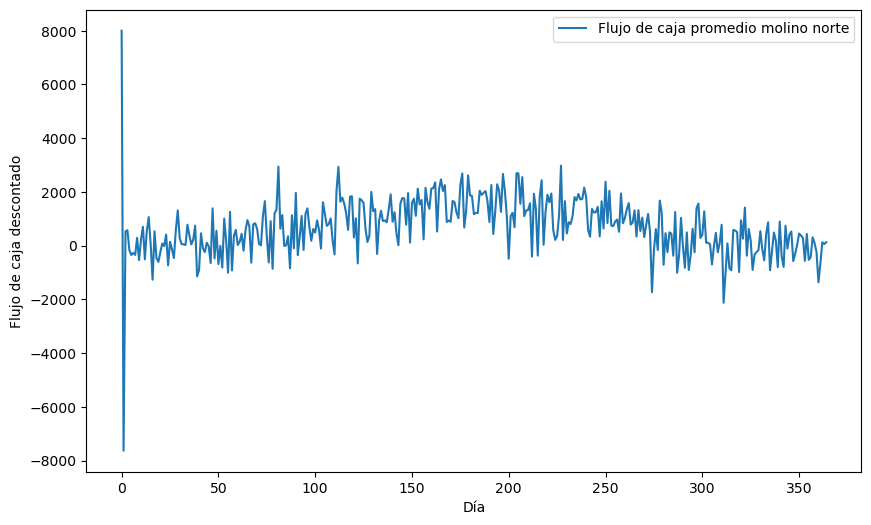

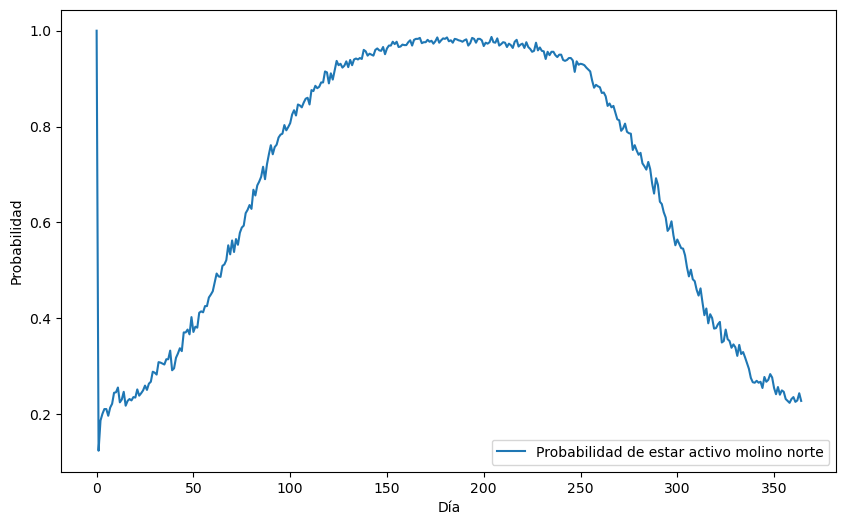

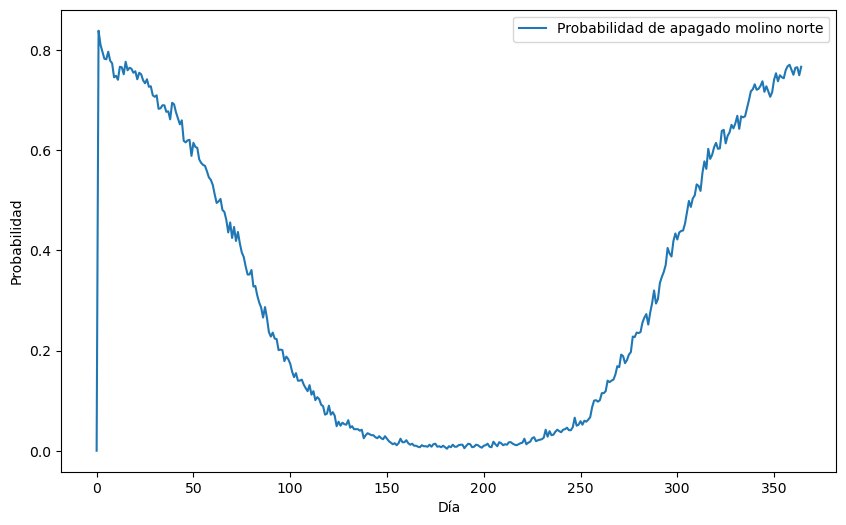

In [45]:
#Gráficos molino norte
plt.figure(figsize=(10, 6))
plt.plot(np.mean(cashflows_norte, axis=0), label="Flujo de caja promedio molino norte")
plt.xlabel("Día")
plt.ylabel("Flujo de caja descontado")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(np.mean(activo_norte, axis=0), label="Probabilidad de estar activo molino norte")
plt.xlabel("Día")
plt.ylabel("Probabilidad")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(np.mean(apagado_norte, axis=0), label="Probabilidad de apagado molino norte")
plt.xlabel("Día")
plt.ylabel("Probabilidad")
plt.legend()
plt.show()

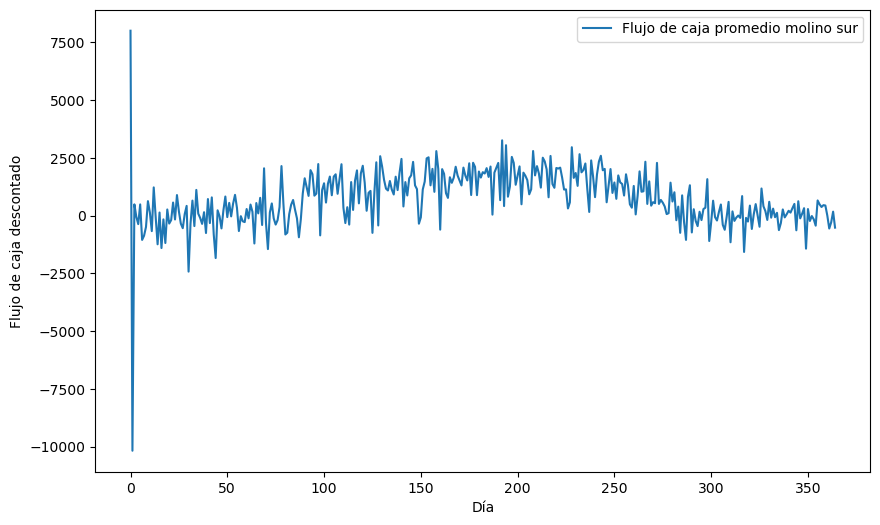

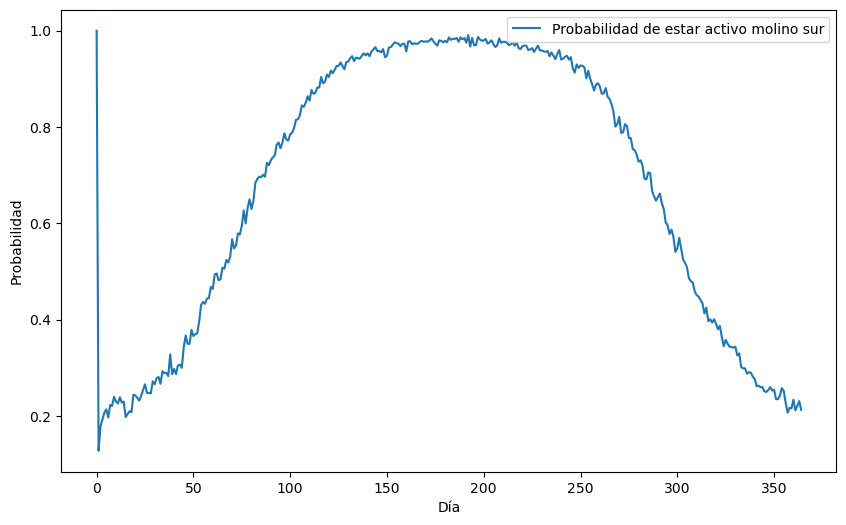

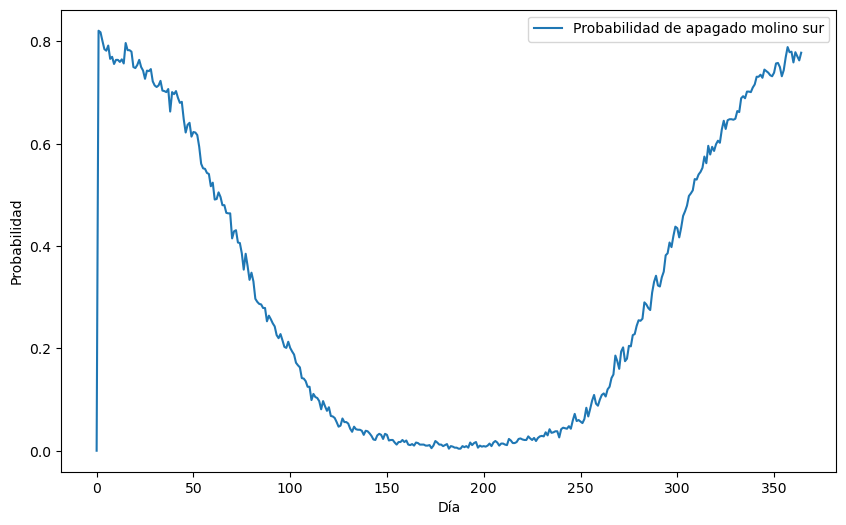

In [46]:
#Gráficos molino sur
plt.figure(figsize=(10, 6))
plt.plot(np.mean(cashflows_sur, axis=0), label="Flujo de caja promedio molino sur")
plt.xlabel("Día")
plt.ylabel("Flujo de caja descontado")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(np.mean(activo_sur, axis=0), label="Probabilidad de estar activo molino sur")
plt.xlabel("Día")
plt.ylabel("Probabilidad")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(np.mean(apagado_sur, axis=0), label="Probabilidad de apagado molino sur")
plt.xlabel("Día")
plt.ylabel("Probabilidad")
plt.legend()
plt.show()

### Ingresos Agosto [8]

In [51]:
#de los cashflows no descontados, tomo aquellos que pertenezcan al mes de agosto -> t entre 212 y 242
ingresos_agosto = []
for i in S:
    ing_mes = 0
    for t in range(212, 243):
        ing_mes += csdn[i, t]
    ingresos_agosto.append(ing_mes)

plt.hist(ingresos_agosto, bins=30)
plt.title('Distribución de ingreso total de agosto')
plt.ylabel('Ingreso')
plt.show()

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
ingresos_agosto = np.mean(csdn[:,212:242], axis=0)

dias_agosto = np.arange(1, len(ingresos_agosto) + 1)  # Días de agosto (1 a 31)
plt.figure(figsize=(10, 6))
plt.plot(dias_agosto, ingresos_agosto, marker='o', linestyle='-', color='b', label='Ingresos diarios promedio')
plt.xlabel('Día de agosto')
plt.ylabel('Ingreso promedio')
plt.title('Ingreso promedio diario de agosto')
plt.legend()
plt.show()

### Promedio de roturas por año [9]

Bajo estrategia óptima vs nunca apagar

In [36]:
# Estrategia óptima con umbral 7 para el molino norte
_, _, _, apagado_optimo_norte, roturas_optima_norte, _,_ = simulate_molino(viento_molino_norte, mejor_umbral_norte, delta)
roturas_medio_optima_norte = np.mean(np.sum(roturas_optima_norte, axis=1))

# Estrategia que nunca apaga (umbral 1000)
_, _, _, _, roturas_nunca_apaga_norte, _,_ = simulate_molino(viento_molino_norte, 1000, delta)
roturas_medio_nunca_apaga_norte = np.mean(np.sum(roturas_nunca_apaga_norte, axis=1))

print(f"Número medio de roturas por año en molino norte (estrategia óptima K = {mejor_umbral_norte}):", roturas_medio_optima_norte)
print("Número medio de roturas por año en molino norte (nunca se apaga):", roturas_medio_nunca_apaga_norte, "\n")

# Estrategia óptima con umbral 8 para el molino sur
_, _, _, apagado_optimo_sur, roturas_optima_sur, _,_ = simulate_molino(viento_molino_sur, mejor_umbral_sur, delta)
roturas_medio_optima_sur = np.mean(np.sum(roturas_optima_sur, axis=1))

# Estrategia que nunca apaga (umbral 1000)
_, _, _, _, roturas_nunca_apaga_sur, _,_ = simulate_molino(viento_molino_sur, 1000, delta)
roturas_medio_nunca_apaga_sur = np.mean(np.sum(roturas_nunca_apaga_sur, axis=1))

print(f"Número medio de roturas por año en molino sur (estrategia óptima K = {mejor_umbral_sur}):", roturas_medio_optima_sur)
print("Número medio de roturas por año en molino sur (nunca se apaga):", roturas_medio_nunca_apaga_sur)

Número medio de roturas por año en molino norte (estrategia óptima K = 7): 4.742666666666667
Número medio de roturas por año en molino norte (nunca se apaga): 9.528733333333333 

Número medio de roturas por año en molino sur (estrategia óptima K = 8): 6.824
Número medio de roturas por año en molino sur (nunca se apaga): 9.572133333333333


Vemos que en promedio se rompe más el molino si no lo apagamos nunca

### Promedio de días que el molino esta inactivo [10]

Bajo la estrategia óptima para cada molino

In [38]:
dias_inactivo_roturas_norte = np.mean(np.sum(roturas_optima_norte, axis=1))
dias_inactivo_apagado_norte = np.mean(np.sum(apagado_optimo_norte, axis=1))
molino_inactivo_norte = dias_inactivo_apagado_norte + dias_inactivo_roturas_norte
print("Número medio de días inactivo del molino norte por año bajo la estrategia óptima:", molino_inactivo_norte)

dias_inactivo_roturas_sur = np.mean(np.sum(roturas_optima_sur, axis=1))
dias_inactivo_apagado_sur = np.mean(np.sum(apagado_optimo_sur, axis=1))
molino_inactivo_sur = dias_inactivo_apagado_sur + dias_inactivo_roturas_sur
print("Número medio de días inactivo del molino sur por año bajo la estrategia óptima:", molino_inactivo_sur)


Número medio de días inactivo del molino norte por año bajo la estrategia óptima: 119.19306666666667
Número medio de días inactivo del molino sur por año bajo la estrategia óptima: 63.6716


### Sensibilidad del VAN a roturas de los molinos [13]

In [28]:
umbrales = [0,1,2,3,4,5,6,7,8,9,10,11,12,1000]
vanes_rotura_250usd_N = []
errores_van_250usd_N = []

for u in umbrales:
    van_rotura_250usd_N, _, _, _, _, error_van_250usd_N,_ = simulate_molino(viento_molino_norte, K, delta, 250000, 1000, 1000, 0.05)
    vanes_rotura_250usd_N.append(van_rotura_250usd_N)
    errores_van_250usd_N.append(error_van_250usd_N)

mejor_umbral_rotura_250usd_N = umbrales[vanes_rotura_250usd_N.index(max(vanes_rotura_250usd_N))]
mejor_van_rotura_250usd_N = vanes_rotura_250usd_N[vanes_rotura_250usd_N.index(max(vanes_rotura_250usd_N))]
se_mejor_umbral_rotura_250usd_N = errores_van_250usd_N[vanes_rotura_250usd_N.index(max(vanes_rotura_250usd_N))]



umbrales = [0,1,2,3,4,5,6,7,8,9,10,11,12,1000]
vanes_rotura_250usd_S = []
errores_van_250usd_S = []

for u in umbrales:
    van_rotura_250usd_S, _, _, _, _, error_van_250usd_S,_ = simulate_molino(viento_molino_sur, K, delta, 250000, 1000, 1000, 0.05)
    vanes_rotura_250usd_S.append(van_rotura_250usd_S)
    errores_van_250usd_S.append(error_van_250usd_S)

mejor_umbral_rotura_250usd_S = umbrales[vanes_rotura_250usd_S.index(max(vanes_rotura_250usd_S))]
mejor_van_rotura_250usd_S = vanes_rotura_250usd_S[vanes_rotura_250usd_S.index(max(vanes_rotura_250usd_S))]
se_mejor_umbral_rotura_250usd_S = errores_van_250usd_S[vanes_rotura_250usd_S.index(max(vanes_rotura_250usd_S))]


In [29]:
print(f"Umbral óptimo para maximización de VAN en molino norte, dado que ahora del arreglo de un molino es 250 mil dólares: {mejor_umbral_rotura_250usd_N}.") 
print(f"VAN esperado de {mejor_van_rotura_250usd_N:.2f} con error estándar de {se_mejor_umbral_rotura_250usd_N:.2f}")
print(f"Umbral óptimo para maximización de VAN en molino sur, dado que ahora del arreglo de un molino es 250 mil dólares: {mejor_umbral_rotura_250usd_S}.")
print(f"VAN esperado: {mejor_van_rotura_250usd_S:.2f} con error estándar de {se_mejor_umbral_rotura_250usd_S:.2f}")

Umbral óptimo para maximización de VAN en molino norte, dado que ahora del arreglo de un molino es 250 mil dólares: 11.
VAN esperado de 18633.67 con error estándar de 4275.56
Umbral óptimo para maximización de VAN en molino sur, dado que ahora del arreglo de un molino es 250 mil dólares: 1000.
VAN esperado: 21952.40 con error estándar de 4320.93
